# Deep Learning & Art: Neural Style Transfer

In this exercise, we implement Neural Style Transfer using Keras. This algorithm was created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

 

## 1 - Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely: a **"content" image (C) and a "style" image (S), to create a "generated" image (G**). 

The generated image G combines the "content" of the image C with the "style" of image S. 

In this example, you are going to generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).
<img src="images/louvre_generated.png" style="width:750px;height:200px;">

Let's see how you can do this. 

***Note that*** this script is run on Google Colab using GPU otherwise it would be really slow on a CPU. 

# 2 - Transfer Learning
Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.

Following the original NST paper, we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers).



In [3]:
# Copy into first cell
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/ML_Learning/CNN_course_NG/"

# Switch to uploaded folder
import os
os.chdir('gdrive/My Drive/ML_Learning/CNN_course_NG/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Loading required packages

%tensorflow_version 1.x

from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications import vgg19
from keras import backend as K
import tensorflow.compat.v1 as tf

import numpy as np
from matplotlib.pyplot import imshow
from scipy.optimize import fmin_l_bfgs_b
import time


In [0]:
# Provide the path of the content and Style image

base_image_path = 'Images/mpi_pic.jpg' 
style_reference_image_path = 'Images/hundertwasserhaus.jpg'

# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [0]:
# util function to open, resize and format pictures into appropriate tensors
# This function (a) loads the image, (b) converts the image into array, and (c) expands the dimension
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input( img)
    return img
  

In [0]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [11]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

In [12]:
print(combination_image.shape)
print(base_image.shape)
print(style_reference_image.shape)

(1, 400, 711, 3)
(1, 400, 711, 3)
(1, 400, 711, 3)


In [0]:

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [14]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')




80142336/80134624 [==============================] - 7s 0us/step






Model loaded.


In [0]:
# get the symbolic outputs of each "key" layer (we gave them unique names). We do by saving the name and output at a layer in a dictionary. 
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Moreover, outputs_dict['layername'] will give the output at the corresponding layer. 

In [0]:
# compute the neural style loss
# first we need to define 4 util functions

# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [0]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [0]:
# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
# Define the weights that give weightage to differnent loss functions
content_weight = 0.025
style_weight = 1.0
total_variation_weight = 1.0
iterations = 10
result_prefix = 'StylishPic_'

In [0]:
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [21]:
# get the gradients of the loss wrt the generated image
grads = K.gradients(loss, combination_image)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

In [0]:
f_outputs = K.function([combination_image], outputs)

In [0]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [0]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


evaluator = Evaluator()

In [0]:
# Generate the initial guess of the stylish image
x = preprocess_image(base_image_path)
noise_ratio = 0.6;
xn = np.random.uniform(-20, 20, (1, x.shape[1], x.shape[2], x.shape[3])).astype('float32')

x = xn* noise_ratio + x*(1-noise_ratio)

In [27]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 6616702000.0
Image saved as StylishPic__at_iteration_0.png
Iteration 0 completed in 18s
Start of iteration 1
Current loss value: 3804397600.0
Image saved as StylishPic__at_iteration_1.png
Iteration 1 completed in 10s
Start of iteration 2
Current loss value: 3050605000.0
Image saved as StylishPic__at_iteration_2.png
Iteration 2 completed in 10s
Start of iteration 3
Current loss value: 2745034800.0
Image saved as StylishPic__at_iteration_3.png
Iteration 3 completed in 10s
Start of iteration 4
Current loss value: 2566636500.0
Image saved as StylishPic__at_iteration_4.png
Iteration 4 completed in 10s
Start of iteration 5
Current loss value: 2437191700.0
Image saved as StylishPic__at_iteration_5.png
Iteration 5 completed in 10s
Start of iteration 6
Current loss value: 2351693800.0
Image saved as StylishPic__at_iteration_6.png
Iteration 6 completed in 10s
Start of iteration 7
Current loss value: 2281997000.0
Image saved as StylishPic__at_iteration_7.p

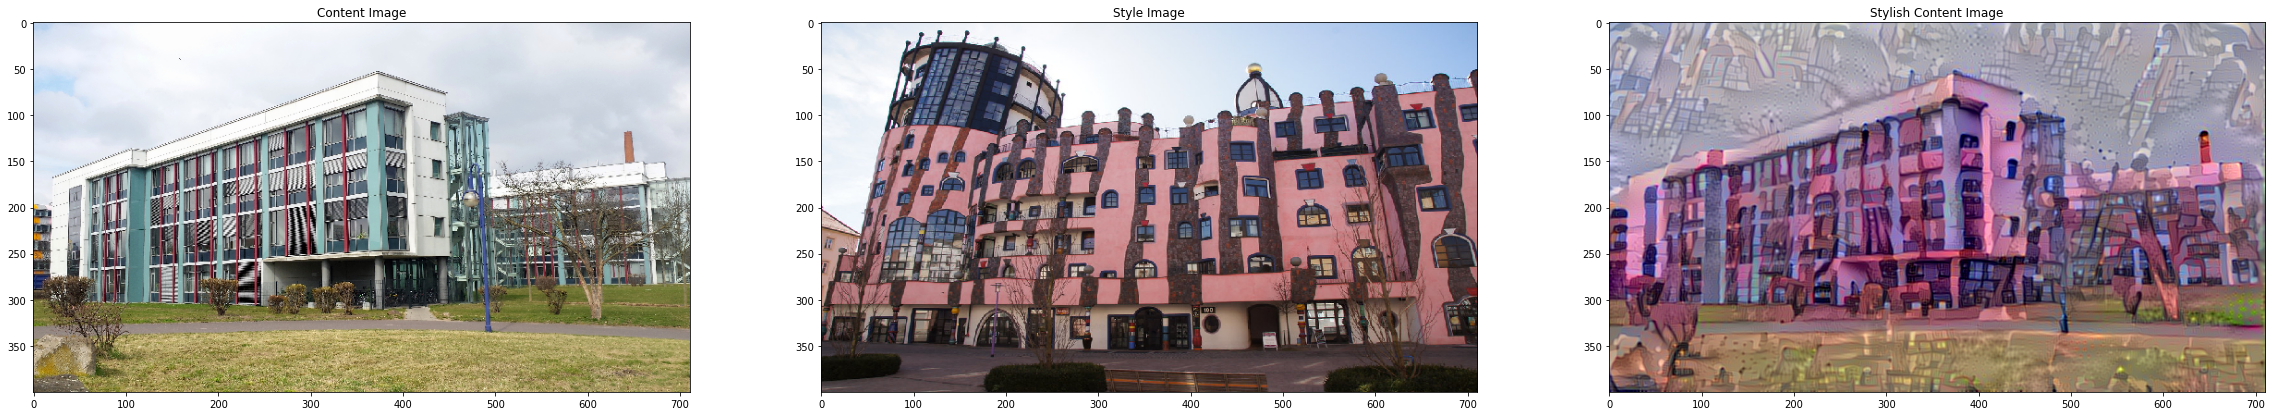

In [64]:
import matplotlib.pyplot as plt

img1 = deprocess_image(preprocess_image(base_image_path)[0])
img2 = deprocess_image(preprocess_image(style_reference_image_path)[0])


interp = 'bilinear'
fig, axs = plt.subplots(1, 3, figsize=(40, 40))

axs[0].set_title('Content Image')
axs[0].imshow(img1 , origin='upper')

axs[1].set_title('Style Image')
axs[1].imshow(img2)

axs[2].set_title('Stylish Content Image')
axs[2].imshow(img, origin='upper')

plt.show()

In [60]:
print(img.shape)
print(img1.shape)
print(type(img))
print(type(img1))


(400, 711, 3)
(400, 711, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


151.061